## Study the Dynamics of the many-body system

Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
from src.qutip_lab.qutip_class import SpinOperator, SpinHamiltonian, SteadyStateSolver
from scipy.fft import fft,ifft
import qutip
from qutip.metrics import fidelity
from typing import List
from qutip import propagator
import os

class Driving:
    def __init__(
        self, h_i: np.array, h_f: np.array, rate: float,tf:float, idx: int, direction: int
    ) -> None:
        self.hi = h_i
        self.hf = h_f
        #self.tf=tf
        self.rate = rate
        self.idx: int = idx
        self.direction = direction

    def field(self, t: float, args):
        return (
           self.hi[self.direction, self.idx] * np.exp(-t * self.rate)
           + (1 - np.exp(-t * self.rate)) * self.hf[self.direction, self.idx]
        )
        # return self.hi[self.direction, self.idx]+t*(self.hf[self.direction, self.idx]-self.hi[self.direction, self.idx])/self.tf

    def get_the_field(self, t: np.ndarray):
        return (
           self.hi[None, self.direction, :] * np.exp(-t[:, None] * self.rate)
           + (1 - np.exp(-t[:, None] * self.rate)) * self.hf[None, self.direction, :]
        )
        # return self.hi[None,self.direction, :]+t[:,None]*(self.hf[None,self.direction, self.idx]-self.hi[None,self.direction, self.idx])/self.tf


class PeriodicDriving:
    def __init__(
        self, h_i: np.array, delta: np.array, rate: float, idx: int, direction: int
    ) -> None:
        self.hi = h_i
        self.delta = delta
        self.rate = rate
        self.idx: int = idx
        self.direction = direction

    def field(self, t: float, args):
        if t<=0.01: 
            print(self.hi[self.direction, self.idx] + (
            self.delta[self.direction, self.idx]
        ) * np.sin(self.rate * t))
        return self.hi[self.direction, self.idx] + (
            self.delta[self.direction, self.idx]
        ) * np.sin(self.rate * t)

    def get_the_field(self, t: np.ndarray):
        return (
            self.hi[None, self.direction, :]
            + (self.delta[None, self.direction, :]) * np.sin(self.rate * t)[:, None]
        )



Data

In [19]:
l=2
rate=0.1
periodic=False

steps = 1000
tf = 10.0
time = np.linspace(0.0, tf, steps)
print(time[0])
hi = np.ones((2, l))
hi[1] = 2.0  # high transverse field
hi[0] = 0.5
# define the final external field
hf = np.ones((2, l))
hf[1] = 1.0
hf[0] = 0.5


# define the delta for the periodic driving
delta = np.ones((2, l))
delta[1] = 0.9
delta[0] = 0.5

0.0


/opt/anaconda3/envs/qutip_env/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


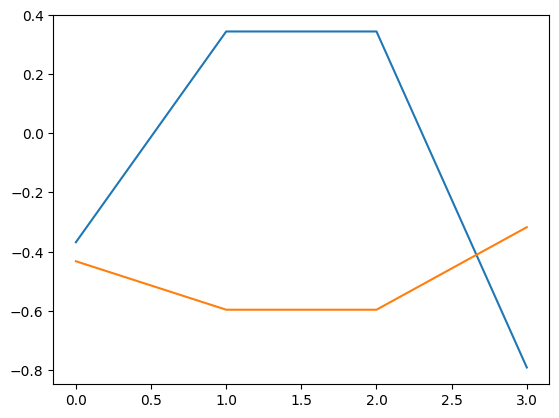

real ground state energy= -4.739226343020452 [-4.73922634 -1.77586399  2.          4.51509034]
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 2.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0. -2.]]

 INITIALIZE THE HAMILTONIAN 

periodic= False 

(1000, 2, 2)


In [26]:
ham0 = SpinHamiltonian(
direction_couplings=[("z", "z")],
pbc=True,
coupling_values=[-1.0],
size=l,
)



hamExtX = SpinOperator(
    index=[("x", i) for i in range(l)], coupling=hi[1], size=l
)
hamExtZ = SpinOperator(
    index=[("z", i) for i in range(l)], coupling=hi[0], size=l
)


eng, psi0 = np.linalg.eigh(ham0.qutip_op  + hamExtX.qutip_op+ hamExtZ.qutip_op)
plt.plot((psi0[:,0]))
plt.plot((psi0[:,-1]))
plt.show()
psi0 = qutip.Qobj(psi0[:, 0], shape=psi0.shape, dims=([[2 for i in range(l)], [1]]))

print("real ground state energy=", eng[0],eng)
# to check if we have the same outcome with the Crank-Nicholson algorithm
# psi = initialize_psi_from_z_and_x(z=-1 * zi[0], x=zi[1])
# psi = psi.detach().numpy()
# for i in range(l):
#     psi_l = qutip.Qobj(psi[i], shape=psi[i].shape, dims=([[2], [1]]))
#     if i == 0:
#         psi0 = psi_l
#     else:
#         psi0 = qutip.tensor(psi0, psi_l)
# compute and check the magnetizations
obs: List[qutip.Qobj] = []
obs_x: List[qutip.Qobj] = []
# for i in range(l):
#     z_op = SpinOperator(index=[("z", i)], coupling=[1.0], size=l, verbose=1)
#     # print(f"x[{i}]=", x.qutip_op, "\n")
#     x_op = SpinOperator(index=[("x", i)], coupling=[1.0], size=l, verbose=0)
#     obs.append(z_op.qutip_op)
#     obs_x.append(x_op.qutip_op)

obs=[SpinOperator(
    index=[("z", i) for i in range(l)], coupling=[1]*l, size=l
).qutip_op]

print(obs[0])

obs_x=[SpinOperator(
    index=[("x", i) for i in range(l)], coupling=[1]*l, size=l
).qutip_op]



print("\n INITIALIZE THE HAMILTONIAN \n")
# build up the time dependent object for the qutip evolution
hamiltonian = [ham0.qutip_op]

print("periodic=", periodic, "\n")
for i in range(1):
    if periodic:
        drive_z = PeriodicDriving(
            h_i=hi,
            delta=delta,
            rate=rate,
            idx=i,
            direction=0,
        )
    else:
        drive_z = Driving(
            h_i=hi,
            h_f=hf,
            rate=rate,
            tf=tf,
            idx=i,
            direction=0,
        )

    hamiltonian.append([obs[i], drive_z.field])

h_z = drive_z.get_the_field(time).reshape(time.shape[0], 1, -1)
for i in range(1):
    if periodic:
        drive_x = PeriodicDriving(
            h_i=hi,
            delta=delta,
            rate=rate,
            idx=i,
            direction=1,
        )
    else:
        drive_x = Driving(
            h_i=hi,
            h_f=hf,
            tf=tf,
            rate=rate,
            idx=i,
            direction=1,
        )
    hamiltonian.append([obs_x[i], drive_x.field])
    
    
h_x = drive_x.get_the_field(time).reshape(time.shape[0], 1, -1)

h = np.append(h_z, h_x, axis=1)
print(h.shape)

# evolution

output = qutip.sesolve(hamiltonian, psi0, time)

psi_t=output.states

# psit=psi0
# psi_t:List=[]
# for t in time:
#     psit=propagator(hamiltonian,t=t)*psit
#     psi_t.append(psit)

In [21]:
norm=np.sqrt(1**2+(0.5*(-1-np.sqrt(5)))**2+(0.5*(-1-np.sqrt(5)))**2+1)

print((0.5*(-1-np.sqrt(5)))/norm)


-0.6015009550075456


Driving

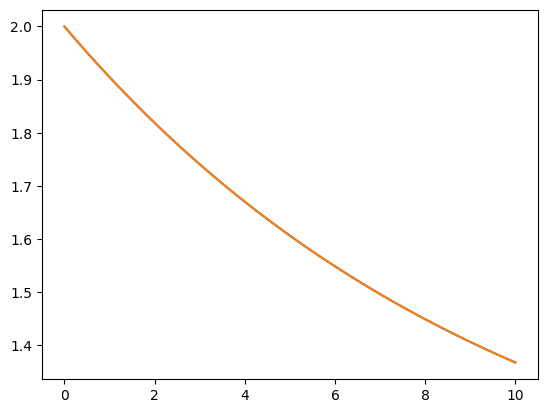

In [22]:
#plt.plot(time,h[:,0])
plt.plot(time,h[:,1])
plt.show()

Compute the instantaneous ground state

In [27]:
spectrum=np.ones((2**l,time.shape[0]))

spectrum_time=np.linspace(0,10,time.shape[0])
psi_gs_t:List=[]
psi_spectrum_t:List=[]
eng_ave_t:List=[]
for i in trange(0,h.shape[0]):
    ham0 = SpinHamiltonian(
        direction_couplings=[("z", "z")],
        pbc=True,
        coupling_values=[-1.0],
        size=l,
    )


    hamExtX = SpinOperator(
        index=[("x", i) for i in range(l)], coupling=h[i,1], size=l
    )
    hamExtZ = SpinOperator(
        index=[("z", i) for i in range(l)], coupling=h[i,0], size=l
    )

    eng_sp, psi_spectrum = np.linalg.eigh(ham0.qutip_op+ hamExtX.qutip_op+hamExtZ.qutip_op)
    spectrum[:,i]=eng_sp[:]
    psi0 = qutip.Qobj(psi_spectrum[:, 0], shape=psi_spectrum.shape, dims=([[2 for i in range(l)], [1]]))
    psi_gs_t.append(psi0)
    psi_spectrum_t.append(psi_spectrum)

    

100%|██████████| 1000/1000 [00:11<00:00, 85.01it/s]


State dynamics

In [29]:
#psi_t=output.states
fid=[]
for i in trange(time.shape[0]):
    fid.append(np.linalg.norm(np.einsum('ai,ia->',psi_gs_t[i].dag(),psi_t[i]))**2)



100%|██████████| 1000/1000 [00:00<00:00, 5845.57it/s]


 Fidelity of the instantaneous ground state

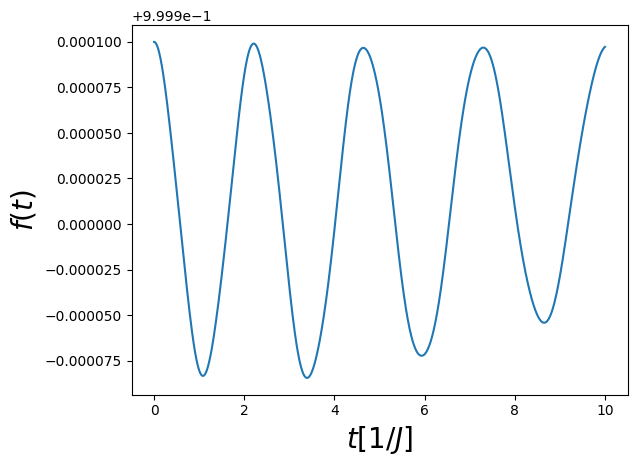

[ 9.99912334e-01-0.00000000e+00j  1.59069491e-06+2.96979658e-06j
 -1.70357999e-07+2.33649298e-07j  8.23824029e-08-5.75772528e-06j
  3.45453340e-05+2.29220149e-05j  5.22789518e-06-6.52576533e-06j
  6.05478022e-07-2.44500701e-06j  1.20093096e-07-1.09437089e-06j
  2.77950977e-08-6.01354116e-07j -8.29087447e-09-3.79083643e-07j
 -4.19876015e-08-2.72814021e-07j -9.15197520e-08-2.84014207e-07j
  1.91492850e-07-5.02196393e-07j  2.07240956e-07+5.45499233e-07j
  4.19598701e-07-1.37148510e-07j  1.46192060e-07-2.12673805e-07j
  5.66755709e-08-1.50196856e-07j  3.19657430e-08-1.08473173e-07j
  2.30524209e-08-8.42471726e-08j  1.86180869e-08-6.89156286e-08j
  1.58508447e-08-5.83259396e-08j  1.38825066e-08-5.05317593e-08j
  1.23752193e-08-4.45338011e-08j  1.11688851e-08-3.97674233e-08j
  1.01753236e-08-3.58872099e-08j  9.34037772e-09-3.26682803e-08j
  8.62809800e-09-2.99569532e-08j  8.01325301e-09-2.76441302e-08j
  7.47738826e-09-2.56499580e-08j  7.00658097e-09-2.39145240e-08j
  6.59006686e-09-2.239194

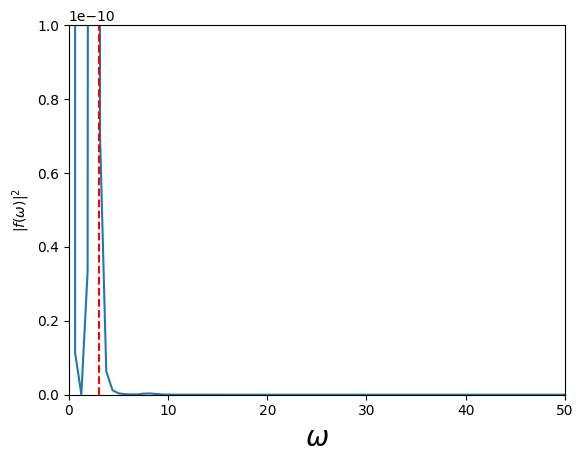

In [30]:

plt.plot(time,fid)
plt.xlabel(r'$t[1/J]$',fontsize=20)
plt.ylabel(r'$f(t)$',fontsize=20)
plt.show()

fid_signal=fft(fid,norm='forward')
w=np.arange(time.shape[0])*(np.pi*2)/tf
print(fid_signal)
plt.plot(w,fid_signal*np.conj(fid_signal))
plt.xlabel(r'$\omega$',fontsize=20)
plt.ylabel(r'$|f(\omega)|^2$')
plt.ylim([0,10**-10])
plt.xlim([0,50])
plt.axvline(x=3,color='red',linestyle='--')
#plt.semilogx()
plt.show()





Data from TDDFT

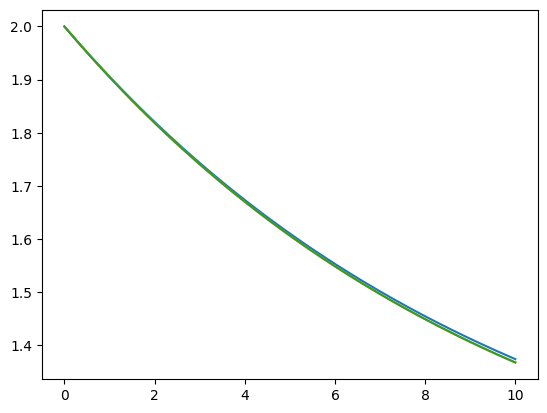

In [31]:
data=np.load('data/kohm_sham_approach/results/dl_functional/tddft_adiabatic_approximation_uniform_model_h_0_5_omega_0_2_ti_0_tf_10_hi_0.0_hf_0.0_omegai_2.0_omegaf_1.0_steps_1000_self_consistent_steps_1_ndata_7_exp_True.npz')



h_dl=data['potential']
engx=data['energy_x']
engz=data['energy_z']
eng=data['energy']
eng_qutip=data['energy_qutip']

z_dl=data['z'][3,:,0]
x_dl=data['x'][3,:,0]
z_qutip=data['z_qutip']
x_qutip=data['x_qutip']
grad=data['gradient']
rates=data['rates']


plt.plot(time,h_dl[3,:,1,0])
plt.plot(time,h[:,1])
plt.show()

Magnetization expectation value

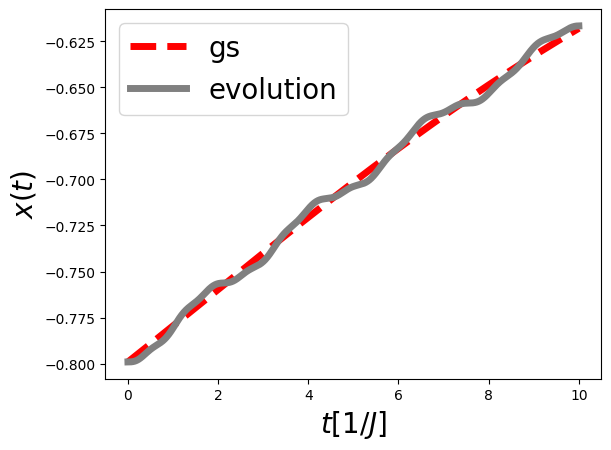

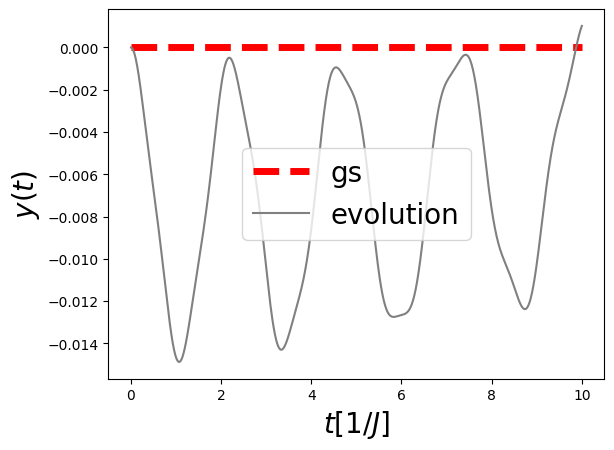

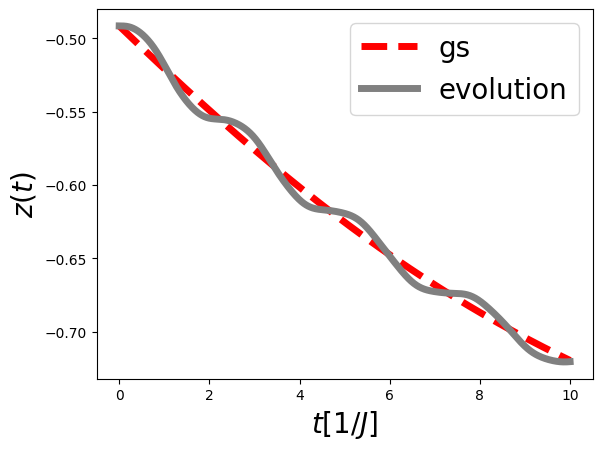

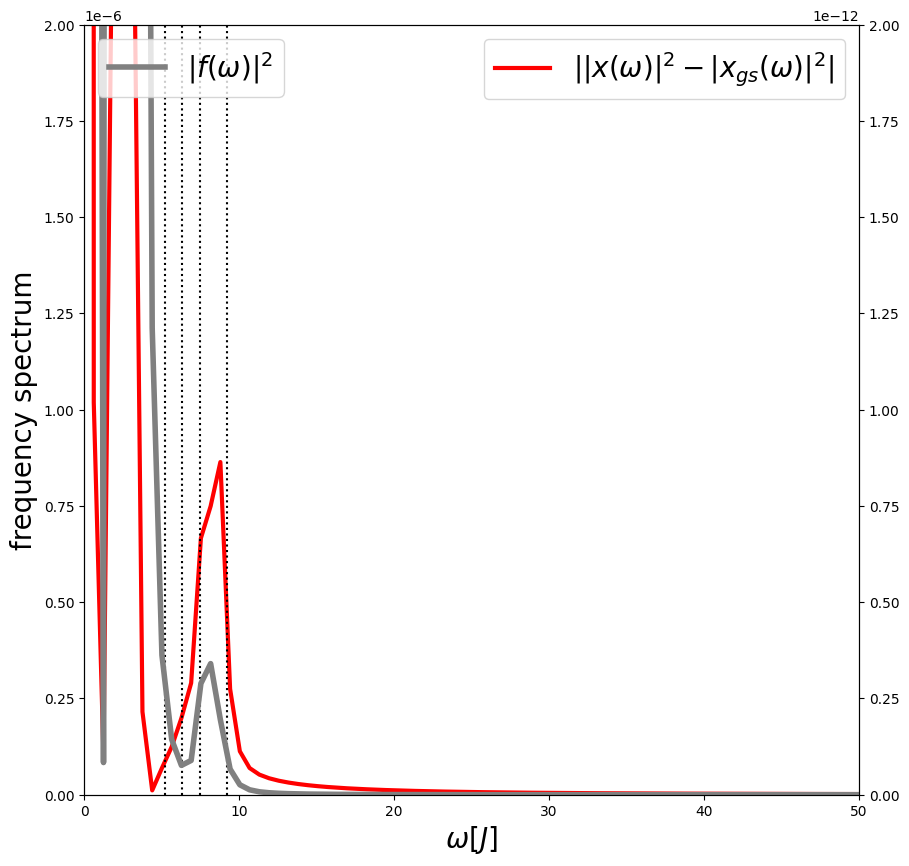

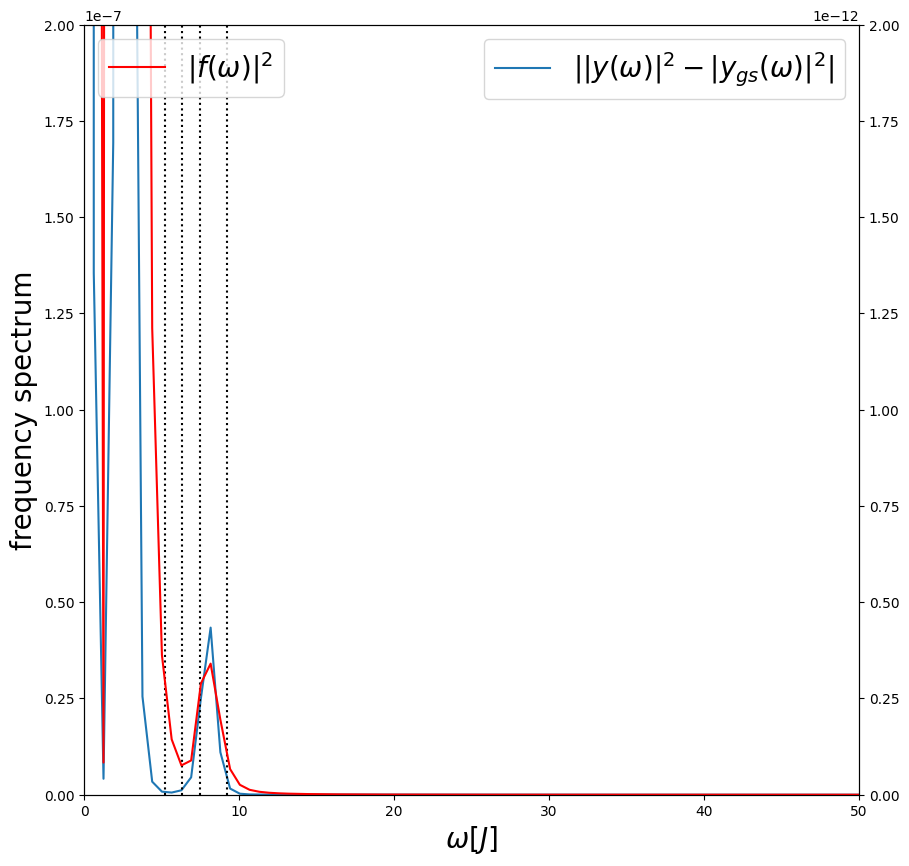

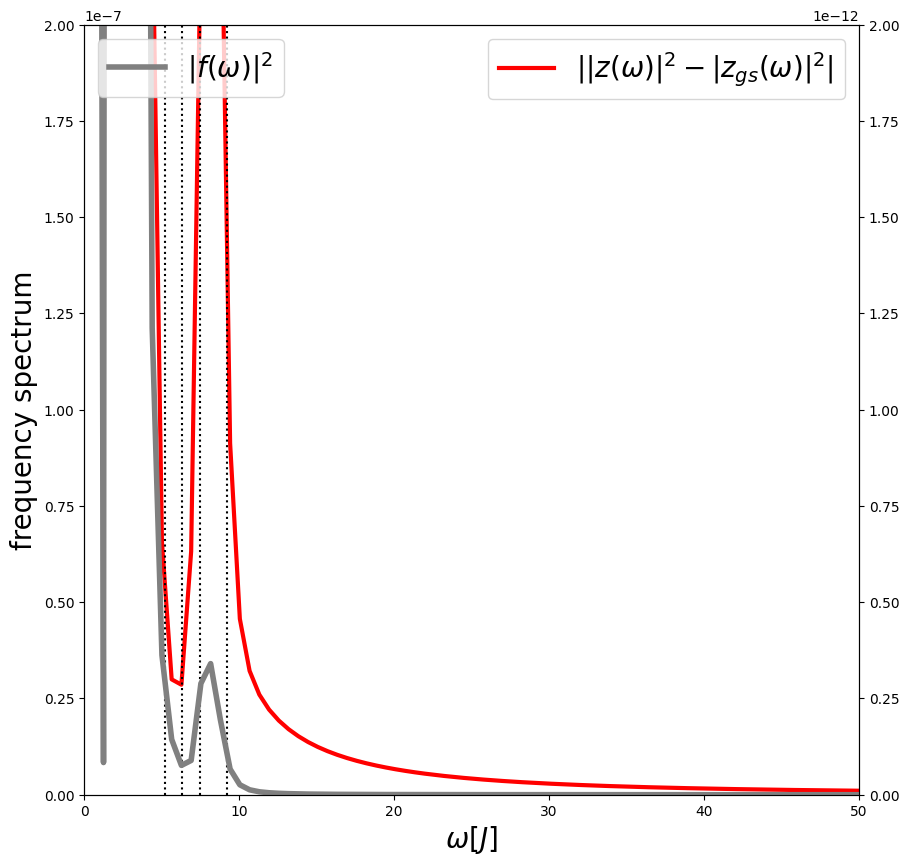

In [32]:
level=3

x=SpinOperator(
        index=[("x", 0)], coupling=[1], size=l
    )
y=SpinOperator(
        index=[("y", 0)], coupling=[1], size=l
    )
z=SpinOperator(
        index=[("z", 0)], coupling=[1], size=l
    )


x_t=[]
x_gs_t=[]

y_t=[]
y_gs_t=[]

z_t=[]
z_gs_t=[]



x_off_diagonal_t=[]
x_spectrum_t=[]
eng_ave_t=[]
for i in range(time.shape[0]):
    x_t.append(x.expect_value(psi_t[i]))
    x_gs_t.append(x.expect_value(psi_gs_t[i]))
    y_t.append(y.expect_value(psi_t[i]))
    y_gs_t.append(y.expect_value(psi_gs_t[i]))
    z_t.append(z.expect_value(psi_t[i]))
    z_gs_t.append(z.expect_value(psi_gs_t[i]))
    
    
    x_off_diagonal_t.append(np.asarray(psi_gs_t[i].dag()* x.qutip_op * psi_t[i]).reshape(-1))
    psi_for_the_average = qutip.Qobj(psi_spectrum_t[i][:, level], shape=psi_spectrum.shape, dims=([[2 for i in range(l)], [1]]))
    x_spectrum_t.append(x.expect_value(psi_for_the_average))
   

plt.figure()
plt.plot(time,np.asarray(x_gs_t),color='red',label='gs',linestyle='--',linewidth=5)
#plt.plot(time,np.asarray(x_dl),color='blue',label='dl',linestyle='--',linewidth=5)
plt.plot(time,np.asarray(x_t),color='grey',label='evolution',linewidth=5)
plt.xlabel(r'$t[1/J]$',fontsize=20)
plt.ylabel(r'$x(t)$',fontsize=20)
plt.legend(fontsize=20)
plt.show()

plt.figure()
plt.plot(time,np.asarray(y_gs_t),color='red',label='gs',linestyle='--',linewidth=5)
plt.plot(time,np.asarray(y_t),color='grey',label='evolution')
plt.xlabel(r'$t[1/J]$',fontsize=20)
plt.ylabel(r'$y(t)$',fontsize=20)
plt.legend(fontsize=20)
plt.show()

plt.figure()
plt.plot(time,np.asarray(z_gs_t),color='red',label='gs',linestyle='--',linewidth=5)
#plt.plot(time,np.asarray(z_dl),color='blue',label='dl',linestyle='--',linewidth=5)
plt.plot(time,np.asarray(z_t),color='grey',label='evolution',linewidth=5)
plt.xlabel(r'$t[1/J]$',fontsize=20)
plt.ylabel(r'$z(t)$',fontsize=20)
plt.legend(fontsize=20)
plt.show()

x_diff=np.asarray(x_gs_t)-np.asarray(x_t)
x_diff_signal=fft(x_diff)

x_qutip_fft=fft(np.asarray(x_t),norm='forward')

# check with
x_gs_fft=fft(np.asarray(x_gs_t),norm='forward')
x_fft=fft(np.asarray(x_t),norm='forward')
x_dl_fft=fft(np.asarray(x_dl),norm='forward')

dx_fft=np.abs(x_fft*np.conj(x_fft)-x_gs_fft*np.conj(x_gs_fft))
dx_dl_fft=np.abs(x_fft*np.conj(x_dl_fft)-x_gs_fft*np.conj(x_gs_fft))

fig,ax=plt.subplots(figsize=(10,10))
ax_twin=ax.twinx()
#ax.plot(w,x_fft*np.conj(x_fft),label=r'$| x|^2(\omega)$')
#ax.plot(w,x_gs_fft*np.conj(x_fft),label=r'$| x_{gs}|^2(\omega)$')
ax.plot(w,dx_fft,label=r'$| | x(\omega)|^2 -| x_{gs}(\omega)|^2|$',color='red',linewidth=3)
#ax.plot(w,dx_dl_fft,label=r'$| | x_{DL}(\omega)|^2 -| x_{gs}(\omega)|^2|$',color='blue',linewidth=3)
ax_twin.plot(w,fid_signal*np.conj(fid_signal),label=r'$| f(\omega)|^2$',color='grey',linewidth=4)
ax.set_xlim([0,50])
ax_twin.set_ylim([0,0.2*10**-11])
ax.set_ylim([0,0.2*10**-5])
ax.legend(fontsize=20)
ax_twin.legend(fontsize=20,loc='upper left')
ax.axvline(x=9.25,color='black',linestyle=':')
ax.axvline(x=7.50,color='black',linestyle=':')

ax.axvline(x=6.3,color='black',linestyle=':')
ax.axvline(x=5.20,color='black',linestyle=':')

#plt.axvline(x=3)
ax.set_ylabel('frequency spectrum',fontsize=20)
ax.set_xlabel(r'$\omega [J]$',fontsize=20)

plt.show()

y_gs_fft=fft(np.asarray(y_gs_t),norm='forward')
y_fft=fft(np.asarray(y_t),norm='forward')

dy_fft=np.abs(y_fft*np.conj(y_fft)-y_gs_fft*np.conj(y_gs_fft))

fig,ax=plt.subplots(figsize=(10,10))
ax_twin=ax.twinx()
#ax.plot(w,x_fft*np.conj(x_fft),label=r'$| x|^2(\omega)$')
#ax.plot(w,x_gs_fft*np.conj(x_fft),label=r'$| x_{gs}|^2(\omega)$')
ax.plot(w,dy_fft,label=r'$| | y(\omega)|^2 -| y_{gs}(\omega)|^2|$')
ax_twin.plot(w,fid_signal*np.conj(fid_signal),color='red',label=r'$| f(\omega)|^2$')
ax.set_xlim([0,50])
ax_twin.set_ylim([0,0.2*10**-11])
ax.set_ylim([0,0.2*10**-6])
ax.legend(fontsize=20)
ax_twin.legend(fontsize=20,loc='upper left')
ax.set_ylabel('frequency spectrum',fontsize=20)
ax.set_xlabel(r'$\omega [J]$',fontsize=20)
ax.axvline(x=9.25,color='black',linestyle=':')
ax.axvline(x=7.50,color='black',linestyle=':')

ax.axvline(x=6.3,color='black',linestyle=':')
ax.axvline(x=5.20,color='black',linestyle=':')

#plt.axvline(x=3)
plt.show()

z_gs_fft=fft(np.asarray(z_gs_t),norm='forward')
z_fft=fft(np.asarray(z_t),norm='forward')
z_dl_fft=fft(np.asarray(z_dl),norm='forward')

dz_fft=np.abs(z_fft*np.conj(z_fft)-z_gs_fft*np.conj(z_gs_fft))
dz_dl_fft=np.abs(z_dl_fft*np.conj(z_dl_fft)-z_gs_fft*np.conj(z_gs_fft))

fig,ax=plt.subplots(figsize=(10,10))
ax_twin=ax.twinx()
#ax.plot(w,x_fft*np.conj(x_fft),label=r'$| x|^2(\omega)$')
#ax.plot(w,x_gs_fft*np.conj(x_fft),label=r'$| x_{gs}|^2(\omega)$')
ax.plot(w,dz_fft,label=r'$| | z(\omega)|^2 -| z_{gs}(\omega)|^2|$',color='red',linewidth=3)
#ax.plot(w,0.01*dz_dl_fft,label=r'$0.01 \times | | z_{DL}(\omega)|^2 -| z_{gs}(\omega)|^2|$',color='blue',linewidth=3)
ax_twin.plot(w,fid_signal*np.conj(fid_signal),label=r'$| f(\omega)|^2$',color='grey',linewidth=4)
ax.set_xlim([0,50])
ax_twin.set_ylim([0,0.2*10**-11])
ax.set_ylim([0,0.2*10**-6])
ax.legend(fontsize=20)
ax_twin.legend(fontsize=20,loc='upper left')
ax.set_ylabel('frequency spectrum',fontsize=20)
ax.set_xlabel(r'$\omega [J]$',fontsize=20)
ax.axvline(x=9.25,color='black',linestyle=':')
ax.axvline(x=7.50,color='black',linestyle=':')

ax.axvline(x=6.3,color='black',linestyle=':')
ax.axvline(x=5.20,color='black',linestyle=':')
#plt.axvline(x=3)
plt.show()


np.savez('data/for_the_analysis/m_gs_fft',x=x_gs_fft,y=y_gs_fft,z=z_gs_fft)


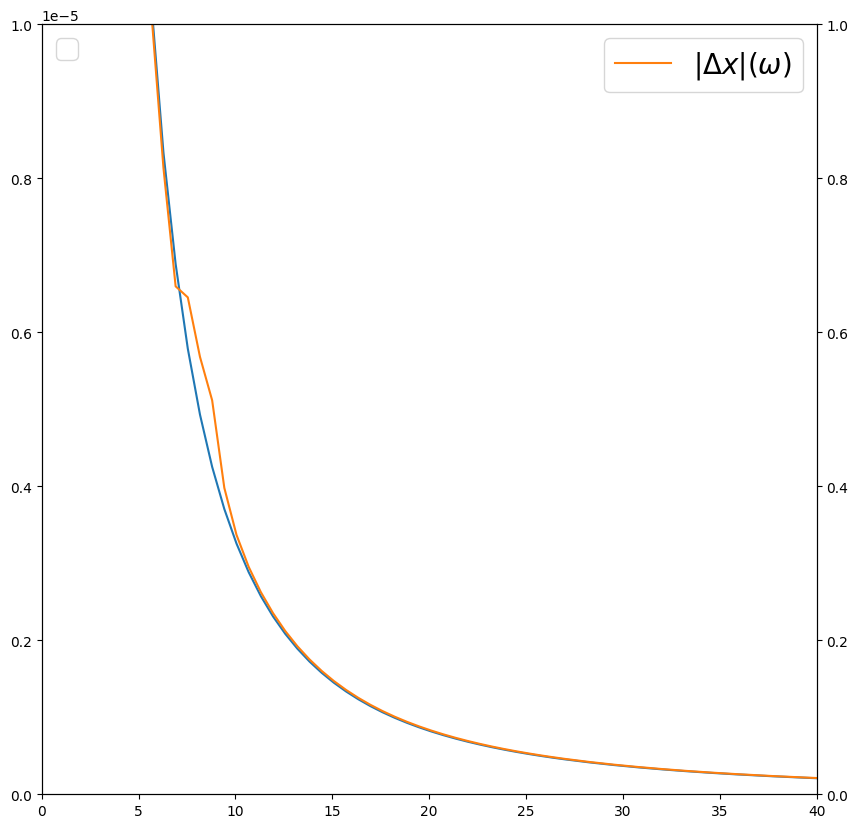

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

In [33]:
w=np.arange(time.shape[0])*(np.pi*2)/tf


x_gs_fft=fft(np.asarray(x_gs_t),norm='forward')


fig,ax=plt.subplots(figsize=(10,10))
ax_twin=ax.twinx()
#ax.plot(w,x_fft*np.conj(x_fft))
ax.plot(w,x_gs_fft*np.conj(x_gs_fft))
#ax.plot(w,np.abs(x_qutip_fft*np.conj(x_qutip_fft)-x_gs_fft*np.conj(x_gs_fft)))
ax.plot(w,x_qutip_fft*np.conj(x_qutip_fft),label=r'$|\Delta x|(\omega)$')
#ax.plot(w,np.abs(x_fft*np.conj(x_fft)-x_gs_fft*np.conj(x_gs_fft)),label=r'$|\Delta x|(\omega)$',color='red',linestyle='--',linewidth=3)

#ax.plot(w,x_fft[3,:,0]*np.conj(x_fft[3,:,0]),color='red',label=r'$|\Delta x_{DL}|(\omega)$')
ax.set_xlim([0,40])
#ax_twin.set_ylim([0,10**-5])
ax.set_ylim([0,10**-5])
ax.legend(fontsize=20)
ax_twin.legend(fontsize=20,loc='upper left')
plt.show()

plt.plot(time,x_dl[3,:,0])
plt.plot(time,x_qutip[3,:,0])
plt.plot(time,x_t)
plt.plot(time,x_gs_t)
plt.show()





fig,ax=plt.subplots(figsize=(10,10))
ax_twin=ax.twinx()
ax.plot(w,x_gs_fft*np.conj(x_gs_fft),label=r'$|\Delta x|^2(\omega)$')
ax_twin.plot(w,fid_signal*np.conj(fid_signal),color='red',label=r'$| f(\omega)|^2$')
ax.set_xlim([0,50])
ax.set_ylim([0,10**-8])
ax_twin.set_ylim([0,10**-4])
ax.legend(fontsize=20)
ax_twin.legend(fontsize=20,loc='upper left')
plt.show()





Check the state

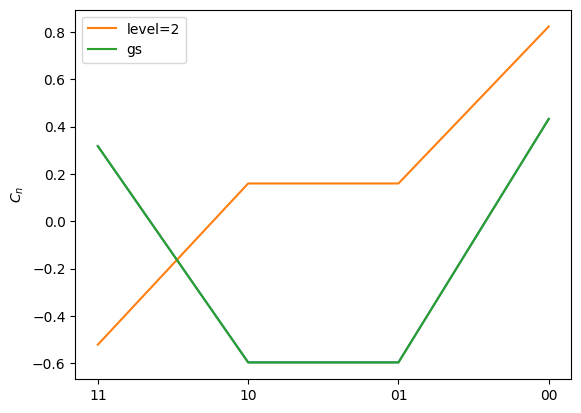

(1, 4)
(1, 4)
0.9999999962873393
1.7207839147300735e-05
(0.0005318669624908567+0j)


In [83]:

t_instant=1
level=2

plt.plot(psi_t[t_instant])
plt.plot(psi_spectrum_t[t_instant][:,level],label=f'level={level}')
#plt.plot(psi_2nd_t[10],label='2nd')
plt.plot(psi_gs_t[t_instant],label='gs')
plt.legend(fontsize=10)
plt.xticks([0,1,2,3],['11','10','01','00'])
plt.ylabel(r'$C_n$')
plt.show()
print(psi_gs_t[0].dag().shape)
print(psi_t[0].dag().shape)


ov_gs_t=np.einsum('ai,ia->',(psi_t[t_instant].dag()),psi_gs_t[t_instant])
ov_level_t=np.einsum('ai,i->',(psi_t[t_instant].dag()),psi_spectrum_t[t_instant][:,level])

print(np.sqrt(np.real(ov_gs_t)**2+np.imag(ov_gs_t)**2))
print(np.sqrt(np.real(ov_level_t)**2+np.imag(ov_level_t)**2))
print(np.einsum('ai,i->',(psi_gs_t[0].dag()),psi_spectrum_t[30][:,level]))


Instantanous eigenstates

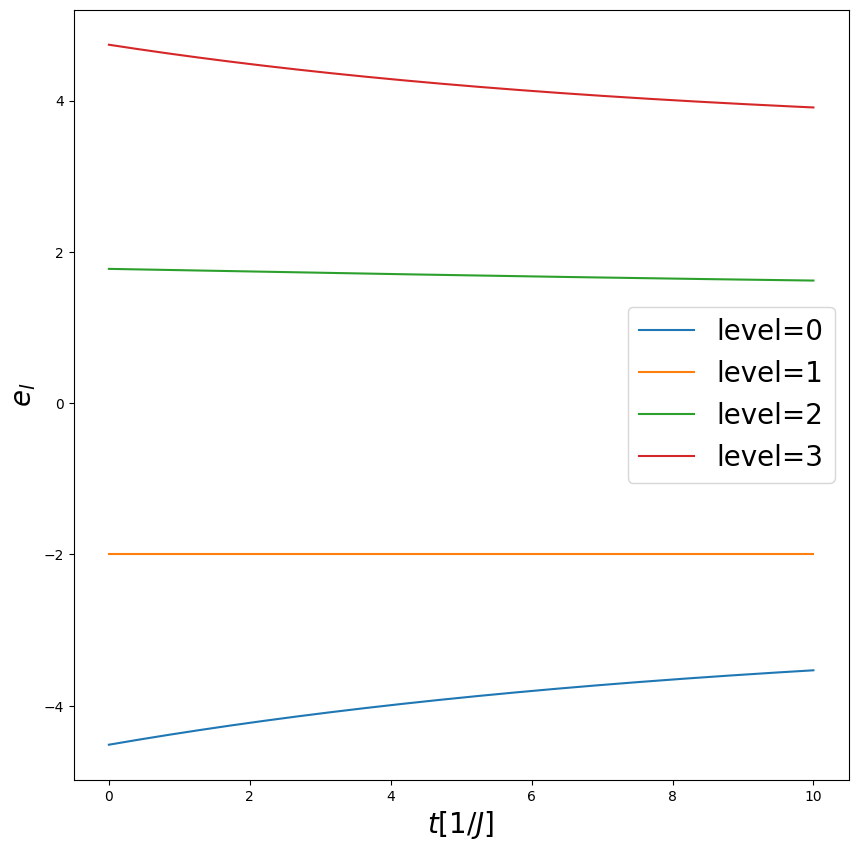

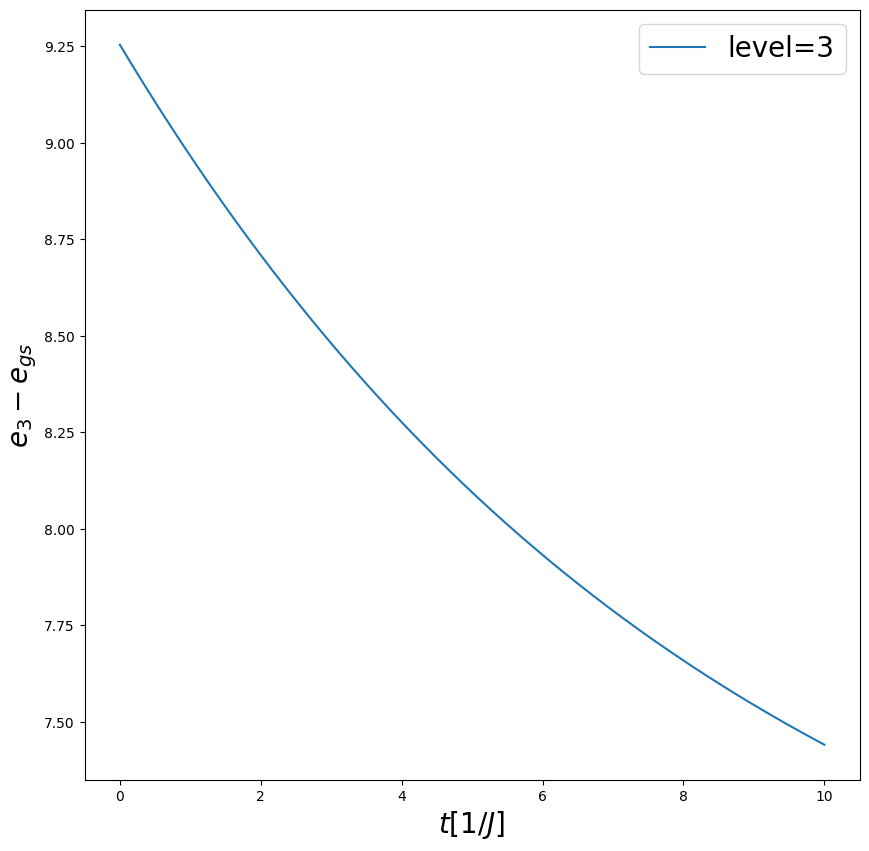

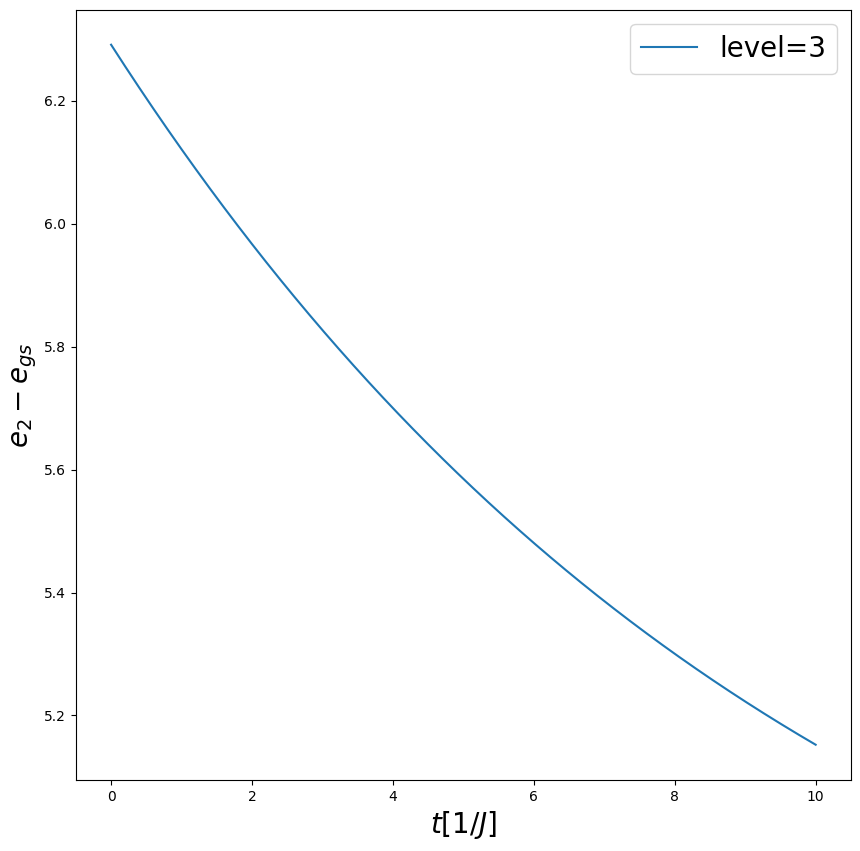

In [21]:
plt.figure(figsize=(10,10))
for i in range(2**l):
    plt.plot(time,spectrum[i,:],label=f'level={i}')
#plt.plot(time,np.asarray(eng_ave_t).reshape(-1),label='ave eng',linestyle='--',linewidth=3,color='red')
plt.legend(fontsize=20)
plt.xlabel(r'$t[1/J]$',fontsize=20)
plt.ylabel(r'$e_{l}$',fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(time,spectrum[-1,:]-spectrum[0,:],label=f'level={i}')
#plt.plot(time,np.asarray(eng_ave_t).reshape(-1),label='ave eng',linestyle='--',linewidth=3,color='red')
plt.legend(fontsize=20)
plt.xlabel(r'$t[1/J]$',fontsize=20)
plt.ylabel(r'$ e_{3}-e_{gs}$',fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
plt.plot(time,spectrum[-2,:]-spectrum[0,:],label=f'level={i}')
#plt.plot(time,np.asarray(eng_ave_t).reshape(-1),label='ave eng',linestyle='--',linewidth=3,color='red')
plt.legend(fontsize=20)
plt.xlabel(r'$t[1/J]$',fontsize=20)
plt.ylabel(r'$ e_{2}-e_{gs}$',fontsize=20)
plt.show()
